<a href="https://colab.research.google.com/github/Wayne-wyyking888/Stat-8931-GenAI/blob/main/chapter1/Chapter_I_Deep_Learning_Quick_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup and Packages load**

In [1]:
## package installation
! pip install accelerate datasets diffusers gym huggingface-hub ipykernel matplotlib numpy opencv-python pandas transformers
## Pytorch installation
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 # customized based on https://pytorch.org/get-started/locally/


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyar

## **In-Class Materials**
* Different types of deep learning & machine learning tools

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
import time

### (1). (Supervised) ResNet18 for CIFAR-10 data Claasification

In [7]:
def print_epoch_stats(epoch, running_loss, train_loader, start_time, end_time):
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Time: {end_time - start_time}s')

def evaluate_model(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy, y_pred

def visualize_predictions(images, predicted, class_names):
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for ax, img, pred in zip(axes, images, predicted):
        img = img.permute(1, 2, 0)  # Convert from CxHxW to HxWxC for matplotlib
        ax.imshow(img)
        ax.set_title(f'Pred: {class_names[pred]}')
        ax.axis('off')
    plt.show()


In [9]:
## training from the scratch
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Change the first conv layer
model.maxpool = nn.Identity()  # Omit max pooling
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjust for number of classes

# Data loaders
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the data
])
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, download=True, transform=transform),
    batch_size=5, shuffle=False)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Check for GPU availability and define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model = model.to(device)

# Training settings
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(4):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    end_time = time.time()
    print_epoch_stats(epoch, running_loss, train_loader, start_time, end_time)

    # Visualization every 2 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        with torch.no_grad():
            accuracy, _ = evaluate_model(model, device, test_loader)
            print(f'Accuracy: {accuracy}')

            images, labels = next(iter(test_loader))
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu().numpy()
            images = images.cpu()
            visualize_predictions(images, predicted, class_names)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Using cuda


KeyboardInterrupt: 

* Visulization With t-SNE (dimension reduction to 2D)


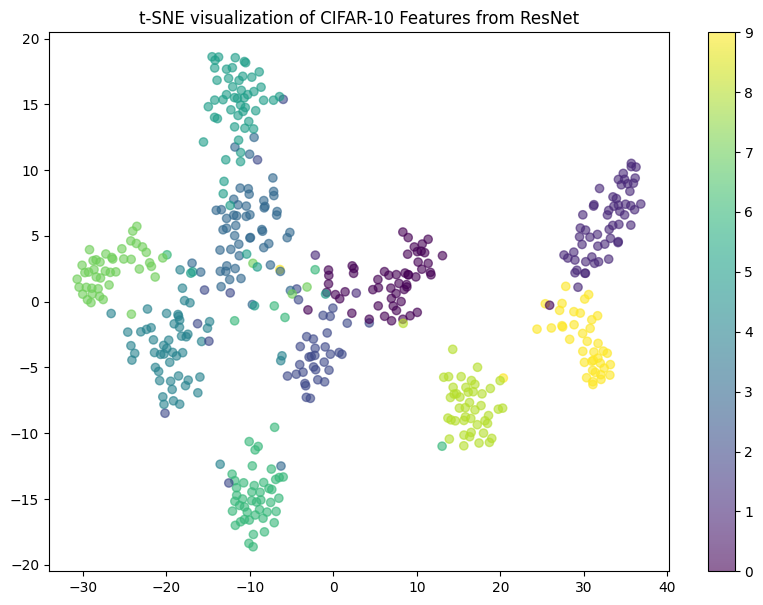

In [ ]:
def extract_features_and_visualize(model, device, data_loader):
    # Modify the model to output features from the last layer before the fully connected layer
    model_modified = torch.nn.Sequential(*(list(model.children())[:-1]))
    model_modified = model_modified.to(device)

    # Extract features
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            output = model_modified(images)
            output = output.view(output.size(0), -1)  # Flatten the outputs
            features.append(output.cpu().numpy())
            labels.append(targets.numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    # t-SNE transformation
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features[:500])  # Using subset for manageability

    # Visualization
    plt.figure(figsize=(10, 7))
    plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels[:500], cmap='viridis', alpha=0.6)

    plt.colorbar()
    plt.title('t-SNE visualization of CIFAR-10 Features from ResNet')
    plt.show()

# evaluate the earlier trained model
extract_features_and_visualize(model, device, train_loader)

### (2). (Unsupervised) VAE, Image Generation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)  # mu layer
        self.fc22 = nn.Linear(400, 20)  # log variance layer
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Training settings
batch_size = 1024
epochs = 10
learning_rate = 1e-3

# Data loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# Initialize the model and send it to the device
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15954019.15it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 482450.87it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4411714.19it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3606005.82it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Using cuda


* VAE loss and training recipes


Epoch 1, Loss: 258.117925, Time: 6.92 sec
Epoch 2, Loss: 184.438302, Time: 6.57 sec


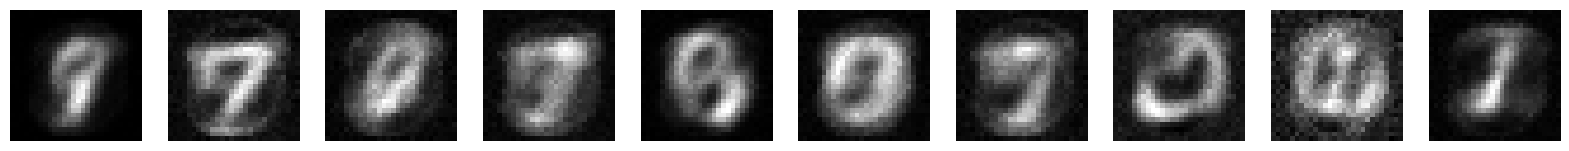

Epoch 3, Loss: 157.737707, Time: 5.82 sec
Epoch 4, Loss: 144.846722, Time: 6.80 sec


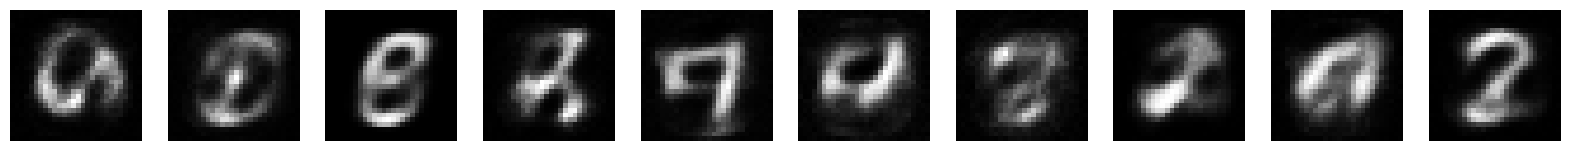

Epoch 5, Loss: 136.056192, Time: 5.88 sec
Epoch 6, Loss: 129.968399, Time: 6.61 sec


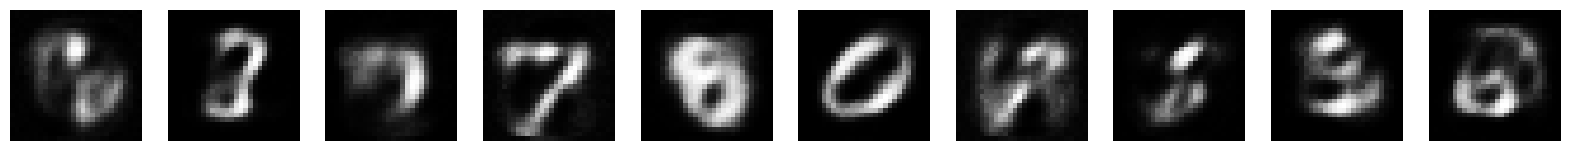

Epoch 7, Loss: 125.752593, Time: 7.55 sec
Epoch 8, Loss: 122.321753, Time: 6.03 sec


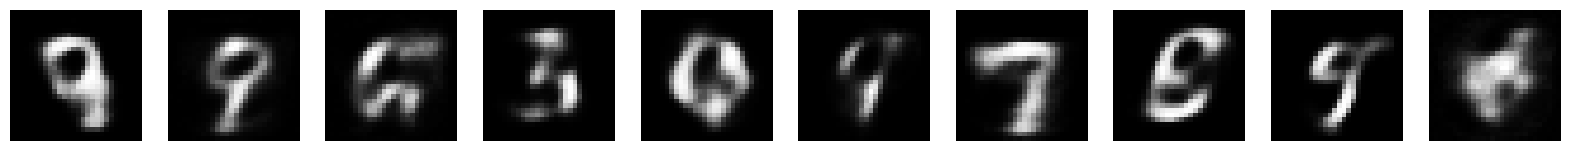

Epoch 9, Loss: 119.680126, Time: 6.61 sec
Epoch 10, Loss: 117.755092, Time: 5.86 sec


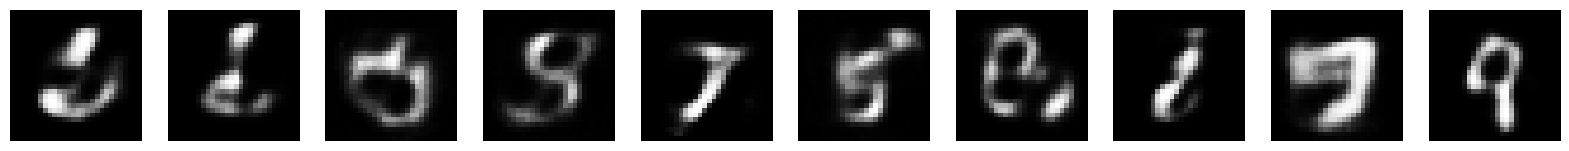

In [ ]:
reconstruction_loss = nn.BCELoss(reduction='sum')
def loss_function(recon_x, x, mu, logvar):
    # Ensure x is reshaped correctly based on its actual batch size
    BCE = reconstruction_loss(recon_x, x.view(x.size(0), -1))  # x.size(0) is the actual batch size
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return BCE + KL_divergence
def visualize_sampled_images(model, device, num_images=10):
    model.eval()
    with torch.no_grad():
        # Sample z from the prior distribution
        z = torch.randn(num_images, 20).to(device)
        sampled_images = model.decode(z)
        sampled_images = sampled_images.view(num_images, 1, 28, 28)
        fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
        for i, ax in enumerate(axes):
            # Move tensor to CPU and convert to numpy for visualization
            img = sampled_images[i].squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        plt.show()

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    start_time = time.time()

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # Send data to the correct device
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    end_time = time.time()
    epoch_duration = end_time - start_time

    average_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Loss: {average_loss:.6f}, Time: {epoch_duration:.2f} sec')

    # Visualize sampled images every two epochs
    if (epoch + 1) % 2 == 0:
        visualize_sampled_images(model, device, num_images=10)

### (3) (Semisupervised Learning): Mixture of labeled/unlabeled data. Use the labeled data to train a model and then give unlabeled data **pseudo-label**. Then *the pair of strong-augmented (hard distorted) input and its original pseudo-label is subsequently treated as labeled data in the training process*

* **Expanding the Decision Boundary**: By applying augmentations, the model is forced to learn more generalized decision boundaries that are robust to noise and small perturbations.

* **Consistency Regularization**: The model should give consistent predictions for both the original and augmented versions of an unlabeled example.

* **Pseudo-Labeling**: The model generates “almost-correct” (set a threshold) labels for the unlabeled data based on its own predictions, which are then used as supervision.

In [3]:
import numpy as np
import random
import torch
from torchvision.utils import make_grid
from torchvision import datasets, models, transforms
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image
import matplotlib.pyplot as plt

PARAMETER_MAX = 10

def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX

def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)

class RandAugment:
    def __init__(self, n=2, m=10):
        self.n = n
        self.m = m
        self.augment_pool = self.rand_augment_pool()

    def __call__(self, img):
        ops = random.sample(self.augment_pool, self.n)
        for op, max_v, bias in ops:
            if max_v is not None:
                v = np.random.randint(1, self.m)
                img = op(img, v=v, max_v=max_v, bias=bias)
            else:
                img = op(img)
        return img

    def rand_augment_pool(self):
        return [
            (PIL.ImageOps.autocontrast, None, None),
            (self.brightness, 1.8, 0.1),
            (self.color, 1.8, 0.1),
            (self.contrast, 1.8, 0.1),
            (self.cutout, 40, None),
            (PIL.ImageOps.equalize, None, None),
            (PIL.ImageOps.invert, None, None),
            (self.posterize, 4, 0),
            (self.rotate, 30, None),
            (self.sharpness, 1.8, 0.1),
            (self.shear_x, 0.3, None),
            (self.shear_y, 0.3, None),
            (self.solarize, 256, None),
            (self.translate_x, 100, None),
            (self.translate_y, 100, None),
        ]

    def brightness(self, img, v, max_v, bias):
        return PIL.ImageEnhance.Brightness(img).enhance(_float_parameter(v, max_v) + bias)

    def color(self, img, v, max_v, bias):
        return PIL.ImageEnhance.Color(img).enhance(_float_parameter(v, max_v) + bias)

    def contrast(self, img, v, max_v, bias):
        return PIL.ImageEnhance.Contrast(img).enhance(_float_parameter(v, max_v) + bias)

    def cutout(self, img, v, max_v, **kwargs):
        if v == 0:
            return img
        w, h = img.size
        x0 = np.random.uniform(0, w)
        y0 = np.random.uniform(0, h)
        x1 = int(max(0, x0 - v / 2.))
        y1 = int(max(0, y0 - v / 2.))
        x2 = int(min(w, x0 + v))
        y2 = int(min(h, y0 + v))
        img = img.copy()
        PIL.ImageDraw.Draw(img).rectangle((x1, y1, x2, y2), (127, 127, 127))
        return img

    def posterize(self, img, v, max_v, bias):
        return PIL.ImageOps.posterize(img, _int_parameter(v, max_v) + bias)

    def rotate(self, img, v, max_v, **kwargs):
        return img.rotate(_float_parameter(v, max_v))

    def sharpness(self, img, v, max_v, bias):
        return PIL.ImageEnhance.Sharpness(img).enhance(_float_parameter(v, max_v) + bias)

    def shear_x(self, img, v, max_v, **kwargs):
        return img.transform(img.size, PIL.Image.AFFINE, (1, _float_parameter(v, max_v), 0, 0, 1, 0))

    def shear_y(self, img, v, max_v, **kwargs):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, _float_parameter(v, max_v), 1, 0))

    def solarize(self, img, v, max_v, **kwargs):
        return PIL.ImageOps.solarize(img, 256 - _int_parameter(v, max_v))

    def translate_x(self, img, v, max_v, **kwargs):
        dx = _float_parameter(v, max_v) * img.size[0]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, dx, 0, 1, 0))

    def translate_y(self, img, v, max_v, **kwargs):
        dy = _float_parameter(v, max_v) * img.size[1]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, dy))

In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split

class AugTransform:
    def __init__(self):
        data_stats = ((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        self.weak = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
            transforms.ToTensor(),
            transforms.Normalize(*data_stats)
        ])
        self.strong = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
            transforms.RandAugment(),
            transforms.ToTensor(),
            transforms.Normalize(*data_stats)
        ])
        self.identity = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(*data_stats)
        ])

    def apply_weak(self, data):
        return self.weak(data)

    def apply_strong(self, data):
        return self.strong(data)

    def apply_identity(self, data):
        return self.identity(data)

class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform_weak=None, transform_strong=None, mode='train'):
        self.dataset = dataset
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong
        self.mode = mode  # 'train' or 'test'

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.mode == 'train':
            image_weak = self.transform_weak(image) if self.transform_weak else image
            image_strong = self.transform_strong(image) if self.transform_strong else image
            return image_weak, image_strong, label
        elif self.mode == 'test':
            image = self.transform_weak(image) if self.transform_weak else image
            return image, label

# Define augmentation transformer
augmenter = AugTransform()

# Load CIFAR-10 dataset
full_dataset = datasets.CIFAR10('./data', train=True, download=True)
test_dataset = datasets.CIFAR10('./data', train=False, download=True)

# Split dataset into labeled and unlabeled subsets
num_labeled = 1000
labeled_indices, unlabeled_indices = train_test_split(range(len(full_dataset)), train_size=num_labeled, random_state=42)
labeled_dataset = Subset(full_dataset, labeled_indices)
unlabeled_dataset = Subset(full_dataset, unlabeled_indices)

# Creating datasets with transformations applied
transformed_labeled_dataset = TransformedDataset(labeled_dataset, transform_weak=augmenter.apply_weak, transform_strong=augmenter.apply_strong, mode='train')
transformed_unlabeled_dataset = TransformedDataset(unlabeled_dataset, transform_weak=augmenter.apply_weak, transform_strong=augmenter.apply_strong, mode='train')
transformed_test_dataset = TransformedDataset(test_dataset, transform_weak=augmenter.apply_identity, mode='test')

# Data loaders
batch_size = 50
labeled_loader = DataLoader(transformed_labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(transformed_unlabeled_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 31181488.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
model = models.resnet18(pretrained=False, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Loss: 1.0523274779319762, Avg Batch Size: 59.2


Epoch 1, Validation accuracy: 0.5228


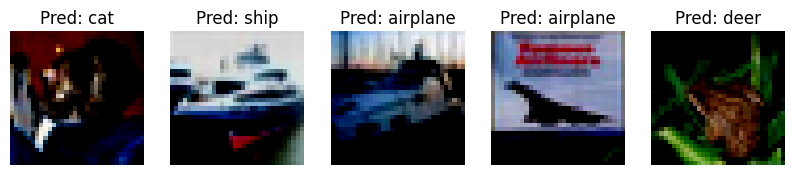

Epoch 2, Loss: 2.517325556278229, Avg Batch Size: 51.8
Epoch 3, Loss: 2.31024888753891, Avg Batch Size: 50.0
Epoch 4, Loss: 2.205516886711121, Avg Batch Size: 50.0
Epoch 5, Loss: 2.11306716799736, Avg Batch Size: 50.0
Epoch 6, Loss: 2.0179406464099885, Avg Batch Size: 50.0
Epoch 7, Loss: 1.96342790722847, Avg Batch Size: 50.0
Epoch 8, Loss: 1.957162868976593, Avg Batch Size: 50.0
Epoch 9, Loss: 1.84565150141716, Avg Batch Size: 50.0
Epoch 10, Loss: 1.7625555276870728, Avg Batch Size: 50.0
Epoch 11, Loss: 1.8192155957221985, Avg Batch Size: 50.1
Epoch 12, Loss: 1.7520131886005401, Avg Batch Size: 50.15
Epoch 13, Loss: 1.6731049835681915, Avg Batch Size: 50.3
Epoch 14, Loss: 1.5743336081504822, Avg Batch Size: 50.85
Epoch 15, Loss: 1.6541197299957275, Avg Batch Size: 51.05
Epoch 16, Loss: 1.4927636623382567, Avg Batch Size: 51.2
Epoch 17, Loss: 1.4049383044242858, Avg Batch Size: 51.45
Epoch 18, Loss: 1.4040898382663727, Avg Batch Size: 52.45
Epoch 19, Loss: 1.3420269012451171, Avg Batch

Epoch 21, Validation accuracy: 0.2794


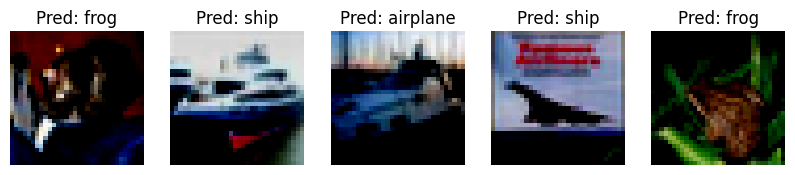

Epoch 22, Loss: 1.2328468143939972, Avg Batch Size: 53.4
Epoch 23, Loss: 1.190130278468132, Avg Batch Size: 53.2
Epoch 24, Loss: 1.1507276982069015, Avg Batch Size: 54.85
Epoch 25, Loss: 1.127571001648903, Avg Batch Size: 53.5
Epoch 26, Loss: 1.0887195110321044, Avg Batch Size: 55.45
Epoch 27, Loss: 1.0960315108299254, Avg Batch Size: 54.55
Epoch 28, Loss: 1.0094518780708313, Avg Batch Size: 55.35
Epoch 29, Loss: 0.9518307000398636, Avg Batch Size: 58.2
Epoch 30, Loss: 1.0814514666795731, Avg Batch Size: 57.35
Epoch 31, Loss: 0.9055616557598114, Avg Batch Size: 58.35
Epoch 32, Loss: 0.8964293241500855, Avg Batch Size: 58.45
Epoch 33, Loss: 0.8560511887073516, Avg Batch Size: 59.3
Epoch 34, Loss: 0.8605520069599152, Avg Batch Size: 59.3
Epoch 35, Loss: 0.8002481311559677, Avg Batch Size: 60.05
Epoch 36, Loss: 0.837750369310379, Avg Batch Size: 59.45
Epoch 37, Loss: 0.8422518849372864, Avg Batch Size: 59.55
Epoch 38, Loss: 0.8046611696481705, Avg Batch Size: 60.5
Epoch 39, Loss: 0.725543

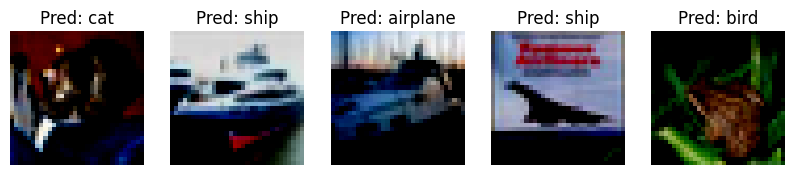

Epoch 42, Loss: 0.7710086420178414, Avg Batch Size: 62.35
Epoch 43, Loss: 0.7835525900125504, Avg Batch Size: 62.3
Epoch 44, Loss: 0.6815252259373665, Avg Batch Size: 63.35
Epoch 45, Loss: 0.6251507326960564, Avg Batch Size: 62.8
Epoch 46, Loss: 0.5710125371813775, Avg Batch Size: 65.05
Epoch 47, Loss: 0.6426787182688714, Avg Batch Size: 66.0
Epoch 48, Loss: 0.5835449680685997, Avg Batch Size: 65.7
Epoch 49, Loss: 0.5605333849787713, Avg Batch Size: 66.75
Epoch 50, Loss: 0.6539120495319366, Avg Batch Size: 63.95
Epoch 51, Loss: 0.5457999005913734, Avg Batch Size: 65.35
Epoch 52, Loss: 0.5616556763648987, Avg Batch Size: 66.3
Epoch 53, Loss: 0.5523223862051964, Avg Batch Size: 67.0
Epoch 54, Loss: 0.5908376410603523, Avg Batch Size: 66.9
Epoch 55, Loss: 0.5751396715641022, Avg Batch Size: 64.85
Epoch 56, Loss: 0.45892101973295213, Avg Batch Size: 69.1
Epoch 57, Loss: 0.4743006229400635, Avg Batch Size: 69.45
Epoch 58, Loss: 0.5036154419183732, Avg Batch Size: 66.6
Epoch 59, Loss: 0.4660

Epoch 61, Validation accuracy: 0.5083


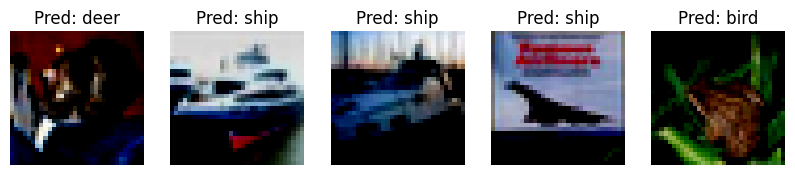

Epoch 62, Loss: 0.4028345629572868, Avg Batch Size: 69.6
Epoch 63, Loss: 0.40327227860689163, Avg Batch Size: 69.65
Epoch 64, Loss: 0.4510343804955482, Avg Batch Size: 70.8
Epoch 65, Loss: 0.42137752324342725, Avg Batch Size: 71.4
Epoch 66, Loss: 0.4099251128733158, Avg Batch Size: 70.95
Epoch 67, Loss: 0.3991689279675484, Avg Batch Size: 73.35
Epoch 68, Loss: 0.3990104518830776, Avg Batch Size: 70.65
Epoch 69, Loss: 0.3774553179740906, Avg Batch Size: 72.35
Epoch 70, Loss: 0.3839951567351818, Avg Batch Size: 70.75
Epoch 71, Loss: 0.3968751348555088, Avg Batch Size: 73.25
Epoch 72, Loss: 0.33319362327456475, Avg Batch Size: 70.8
Epoch 73, Loss: 0.3867432802915573, Avg Batch Size: 71.25
Epoch 74, Loss: 0.34881031364202497, Avg Batch Size: 72.6
Epoch 75, Loss: 0.34073274210095406, Avg Batch Size: 73.7
Epoch 76, Loss: 0.40266428589820863, Avg Batch Size: 72.2
Epoch 77, Loss: 0.3972611904144287, Avg Batch Size: 73.0
Epoch 78, Loss: 0.4081202320754528, Avg Batch Size: 72.3
Epoch 79, Loss: 0

Epoch 81, Validation accuracy: 0.4883


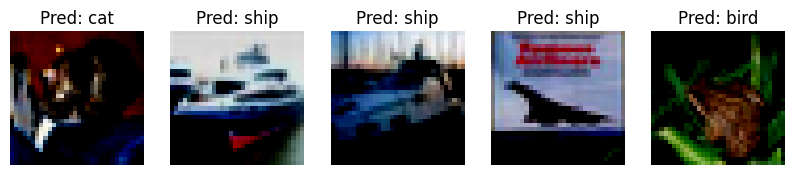

Epoch 82, Loss: 0.3413355454802513, Avg Batch Size: 74.2
Epoch 83, Loss: 0.30401244908571246, Avg Batch Size: 71.85
Epoch 84, Loss: 0.32771345749497416, Avg Batch Size: 76.7
Epoch 85, Loss: 0.3058433495461941, Avg Batch Size: 75.9
Epoch 86, Loss: 0.2748668409883976, Avg Batch Size: 75.05
Epoch 87, Loss: 0.3195136435329914, Avg Batch Size: 75.75
Epoch 88, Loss: 0.3044276885688305, Avg Batch Size: 75.4
Epoch 89, Loss: 0.3311652712523937, Avg Batch Size: 75.2
Epoch 90, Loss: 0.31866413056850434, Avg Batch Size: 73.95
Epoch 91, Loss: 0.26806929633021354, Avg Batch Size: 76.15
Epoch 92, Loss: 0.3251760557293892, Avg Batch Size: 75.45
Epoch 93, Loss: 0.2713648423552513, Avg Batch Size: 76.1
Epoch 94, Loss: 0.28392295688390734, Avg Batch Size: 77.25
Epoch 95, Loss: 0.27530404180288315, Avg Batch Size: 75.5
Epoch 96, Loss: 0.2897616811096668, Avg Batch Size: 75.15
Epoch 97, Loss: 0.2615489013493061, Avg Batch Size: 73.55
Epoch 98, Loss: 0.2776237323880196, Avg Batch Size: 75.85
Epoch 99, Loss:

Epoch 101, Validation accuracy: 0.5092


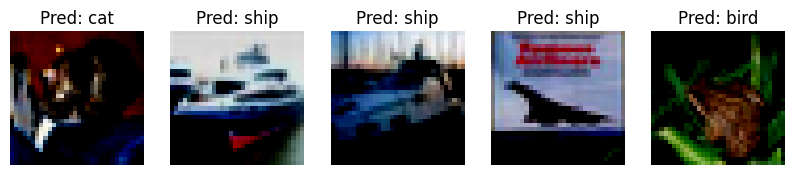

Epoch 102, Loss: 0.2835440434515476, Avg Batch Size: 75.9
Epoch 103, Loss: 0.2772344946861267, Avg Batch Size: 76.8
Epoch 104, Loss: 0.2754398312419653, Avg Batch Size: 76.7
Epoch 105, Loss: 0.253007260710001, Avg Batch Size: 75.6
Epoch 106, Loss: 0.2962258983403444, Avg Batch Size: 76.9
Epoch 107, Loss: 0.2631708584725857, Avg Batch Size: 76.3
Epoch 108, Loss: 0.3108571723103523, Avg Batch Size: 77.7
Epoch 109, Loss: 0.2723495986312628, Avg Batch Size: 73.45
Epoch 110, Loss: 0.23787140622735023, Avg Batch Size: 77.4
Epoch 111, Loss: 0.2886135742068291, Avg Batch Size: 75.45
Epoch 112, Loss: 0.26703029237687587, Avg Batch Size: 74.5
Epoch 113, Loss: 0.2518667135387659, Avg Batch Size: 79.9
Epoch 114, Loss: 0.28701082020998003, Avg Batch Size: 77.5
Epoch 115, Loss: 0.2414142057299614, Avg Batch Size: 77.9
Epoch 116, Loss: 0.30205632746219635, Avg Batch Size: 77.3
Epoch 117, Loss: 0.2367112323641777, Avg Batch Size: 76.2
Epoch 118, Loss: 0.25533384680747984, Avg Batch Size: 77.55
Epoch 1

Epoch 121, Validation accuracy: 0.5392


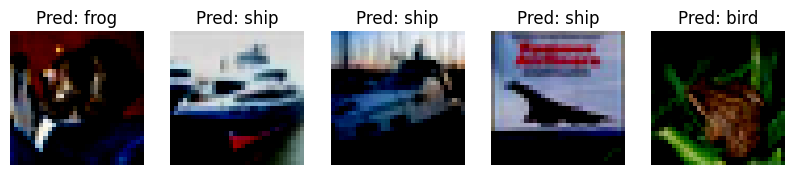

Epoch 122, Loss: 0.2616071976721287, Avg Batch Size: 76.35
Epoch 123, Loss: 0.2472674012184143, Avg Batch Size: 77.65
Epoch 124, Loss: 0.2722793210297823, Avg Batch Size: 77.2
Epoch 125, Loss: 0.22500170283019544, Avg Batch Size: 77.0
Epoch 126, Loss: 0.2746391844004393, Avg Batch Size: 77.2
Epoch 127, Loss: 0.24520826041698457, Avg Batch Size: 78.15
Epoch 128, Loss: 0.26998792216181755, Avg Batch Size: 76.5
Epoch 129, Loss: 0.2487349260598421, Avg Batch Size: 77.3
Epoch 130, Loss: 0.21081733144819736, Avg Batch Size: 78.45
Epoch 131, Loss: 0.24602919444441795, Avg Batch Size: 80.2
Epoch 132, Loss: 0.24219175353646277, Avg Batch Size: 75.95
Epoch 133, Loss: 0.2477842468768358, Avg Batch Size: 78.6
Epoch 134, Loss: 0.26534069031476976, Avg Batch Size: 78.3
Epoch 135, Loss: 0.2629461791366339, Avg Batch Size: 77.95
Epoch 136, Loss: 0.24999309070408343, Avg Batch Size: 76.5
Epoch 137, Loss: 0.23960365056991578, Avg Batch Size: 79.0
Epoch 138, Loss: 0.24480591155588627, Avg Batch Size: 78.

Epoch 141, Validation accuracy: 0.538


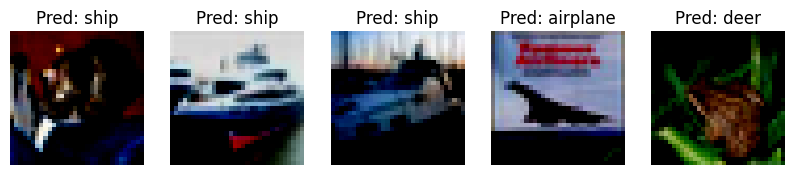

Epoch 142, Loss: 0.1988144747912884, Avg Batch Size: 78.85
Epoch 143, Loss: 0.22121451906859874, Avg Batch Size: 78.85
Epoch 144, Loss: 0.21310238242149354, Avg Batch Size: 77.55
Epoch 145, Loss: 0.23630873262882232, Avg Batch Size: 78.75
Epoch 146, Loss: 0.23029938600957395, Avg Batch Size: 79.45
Epoch 147, Loss: 0.2630336478352547, Avg Batch Size: 78.75
Epoch 148, Loss: 0.24399017505347728, Avg Batch Size: 79.45
Epoch 149, Loss: 0.2047863382846117, Avg Batch Size: 78.45
Epoch 150, Loss: 0.25381291285157204, Avg Batch Size: 79.0
Epoch 151, Loss: 0.19134679809212685, Avg Batch Size: 78.75
Epoch 152, Loss: 0.26752130351960657, Avg Batch Size: 79.55
Epoch 153, Loss: 0.2618112377822399, Avg Batch Size: 79.55
Epoch 154, Loss: 0.2480081170797348, Avg Batch Size: 76.4
Epoch 155, Loss: 0.23139796890318393, Avg Batch Size: 78.25
Epoch 156, Loss: 0.24058022312819957, Avg Batch Size: 78.65
Epoch 157, Loss: 0.1876727297902107, Avg Batch Size: 77.05
Epoch 158, Loss: 0.2519394986331463, Avg Batch S

Epoch 161, Validation accuracy: 0.4492


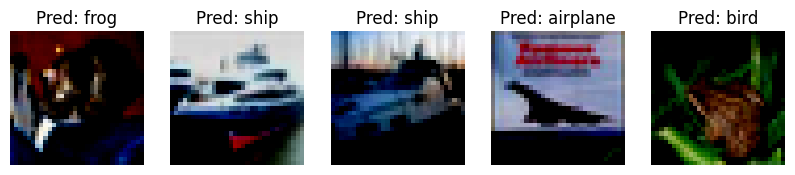

Epoch 162, Loss: 0.18206519186496734, Avg Batch Size: 78.7
Epoch 163, Loss: 0.22827416211366652, Avg Batch Size: 80.75
Epoch 164, Loss: 0.20645706057548524, Avg Batch Size: 80.0
Epoch 165, Loss: 0.23385510966181755, Avg Batch Size: 78.75
Epoch 166, Loss: 0.20180371440947056, Avg Batch Size: 79.3
Epoch 167, Loss: 0.2210027128458023, Avg Batch Size: 79.2
Epoch 168, Loss: 0.24540600478649138, Avg Batch Size: 78.4
Epoch 169, Loss: 0.24047708436846732, Avg Batch Size: 76.8
Epoch 170, Loss: 0.21800093576312066, Avg Batch Size: 79.85
Epoch 171, Loss: 0.22866252325475217, Avg Batch Size: 79.65
Epoch 172, Loss: 0.19328124187886714, Avg Batch Size: 77.7
Epoch 173, Loss: 0.21938745453953742, Avg Batch Size: 79.25
Epoch 174, Loss: 0.192376945912838, Avg Batch Size: 76.5
Epoch 175, Loss: 0.24187546633183957, Avg Batch Size: 80.35
Epoch 176, Loss: 0.19133838620036842, Avg Batch Size: 78.8
Epoch 177, Loss: 0.2037996996194124, Avg Batch Size: 79.45
Epoch 178, Loss: 0.22882560528814794, Avg Batch Size:

Epoch 181, Validation accuracy: 0.5627


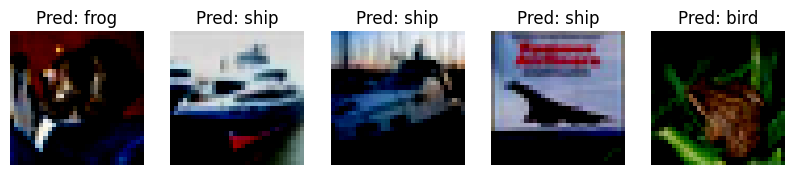

Epoch 182, Loss: 0.221043773368001, Avg Batch Size: 77.55
Epoch 183, Loss: 0.2141765546053648, Avg Batch Size: 79.3
Epoch 184, Loss: 0.21972665265202523, Avg Batch Size: 78.2
Epoch 185, Loss: 0.1850824471563101, Avg Batch Size: 79.4
Epoch 186, Loss: 0.19496446345001459, Avg Batch Size: 78.0
Epoch 187, Loss: 0.2347204267978668, Avg Batch Size: 79.3
Epoch 188, Loss: 0.21809607669711112, Avg Batch Size: 78.5
Epoch 189, Loss: 0.21594851426780223, Avg Batch Size: 80.7
Epoch 190, Loss: 0.21507723443210125, Avg Batch Size: 79.05
Epoch 191, Loss: 0.20773813538253308, Avg Batch Size: 79.7
Epoch 192, Loss: 0.18099588081240653, Avg Batch Size: 78.9
Epoch 193, Loss: 0.19352466464042664, Avg Batch Size: 78.65
Epoch 194, Loss: 0.223211919516325, Avg Batch Size: 81.1
Epoch 195, Loss: 0.2142711143940687, Avg Batch Size: 78.2
Epoch 196, Loss: 0.23686154410243035, Avg Batch Size: 79.8
Epoch 197, Loss: 0.20103982463479042, Avg Batch Size: 79.45
Epoch 198, Loss: 0.19708776120096444, Avg Batch Size: 80.55


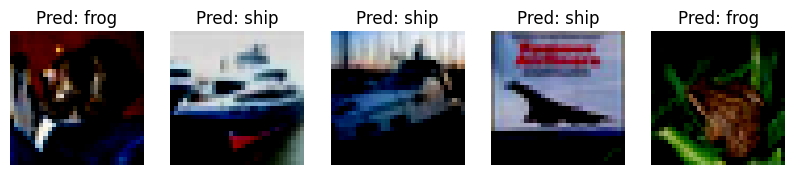

Epoch 202, Loss: 0.19112211912870408, Avg Batch Size: 78.5
Epoch 203, Loss: 0.19716595746576787, Avg Batch Size: 81.3
Epoch 204, Loss: 0.21974381655454636, Avg Batch Size: 81.3
Epoch 205, Loss: 0.18868447542190553, Avg Batch Size: 81.05
Epoch 206, Loss: 0.21244811303913594, Avg Batch Size: 80.35
Epoch 207, Loss: 0.19865541271865367, Avg Batch Size: 82.3
Epoch 208, Loss: 0.20227748677134513, Avg Batch Size: 78.95
Epoch 209, Loss: 0.18295238129794597, Avg Batch Size: 80.15
Epoch 210, Loss: 0.20898617170751094, Avg Batch Size: 78.55
Epoch 211, Loss: 0.18683806471526623, Avg Batch Size: 79.8
Epoch 212, Loss: 0.1914355404675007, Avg Batch Size: 82.2
Epoch 213, Loss: 0.20962785501033068, Avg Batch Size: 80.3
Epoch 214, Loss: 0.2065162293612957, Avg Batch Size: 78.45
Epoch 215, Loss: 0.21548310592770575, Avg Batch Size: 79.75
Epoch 216, Loss: 0.18840256035327912, Avg Batch Size: 81.0
Epoch 217, Loss: 0.1669207312166691, Avg Batch Size: 81.4
Epoch 218, Loss: 0.18388587683439256, Avg Batch Size

Epoch 221, Validation accuracy: 0.5738


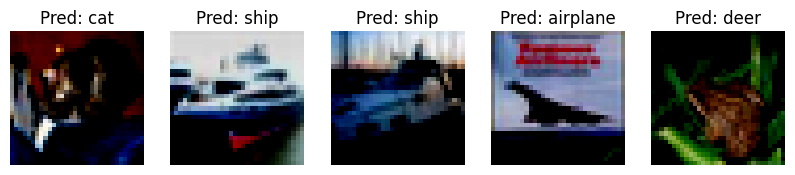

Epoch 222, Loss: 0.1957582276314497, Avg Batch Size: 82.35
Epoch 223, Loss: 0.21045760586857795, Avg Batch Size: 81.15
Epoch 224, Loss: 0.17471547648310662, Avg Batch Size: 79.7
Epoch 225, Loss: 0.1943106699734926, Avg Batch Size: 81.45
Epoch 226, Loss: 0.19237625710666179, Avg Batch Size: 79.35
Epoch 227, Loss: 0.22340782657265662, Avg Batch Size: 81.8
Epoch 228, Loss: 0.17797702215611935, Avg Batch Size: 80.6
Epoch 229, Loss: 0.20396789647638797, Avg Batch Size: 81.85
Epoch 230, Loss: 0.19804260656237602, Avg Batch Size: 79.15
Epoch 231, Loss: 0.20683637410402297, Avg Batch Size: 81.7
Epoch 232, Loss: 0.17865332812070847, Avg Batch Size: 80.8
Epoch 233, Loss: 0.2247892592102289, Avg Batch Size: 79.75
Epoch 234, Loss: 0.18501228243112564, Avg Batch Size: 79.3
Epoch 235, Loss: 0.16461825370788574, Avg Batch Size: 81.95
Epoch 236, Loss: 0.19693373842164874, Avg Batch Size: 80.2
Epoch 237, Loss: 0.1951334908604622, Avg Batch Size: 81.2
Epoch 238, Loss: 0.1776530809700489, Avg Batch Size:

Epoch 241, Validation accuracy: 0.5626


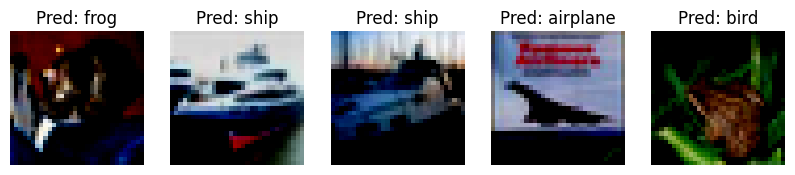

Epoch 242, Loss: 0.20236160196363925, Avg Batch Size: 80.8
Epoch 243, Loss: 0.17212522514164447, Avg Batch Size: 79.9
Epoch 244, Loss: 0.18709275126457214, Avg Batch Size: 83.0
Epoch 245, Loss: 0.18294489309191703, Avg Batch Size: 79.7
Epoch 246, Loss: 0.18597359210252762, Avg Batch Size: 80.1
Epoch 247, Loss: 0.17050684653222561, Avg Batch Size: 80.1
Epoch 248, Loss: 0.18124777153134347, Avg Batch Size: 81.2
Epoch 249, Loss: 0.20031221807003022, Avg Batch Size: 83.3
Epoch 250, Loss: 0.1943243708461523, Avg Batch Size: 81.25
Epoch 251, Loss: 0.2065049558877945, Avg Batch Size: 80.35
Epoch 252, Loss: 0.20813840664923192, Avg Batch Size: 81.05
Epoch 253, Loss: 0.15811366122215986, Avg Batch Size: 80.55
Epoch 254, Loss: 0.20014611296355725, Avg Batch Size: 80.0
Epoch 255, Loss: 0.19229905270040035, Avg Batch Size: 81.2
Epoch 256, Loss: 0.20030812472105025, Avg Batch Size: 82.0
Epoch 257, Loss: 0.18003024086356162, Avg Batch Size: 80.4
Epoch 258, Loss: 0.19051821194589139, Avg Batch Size: 

Epoch 261, Validation accuracy: 0.5264


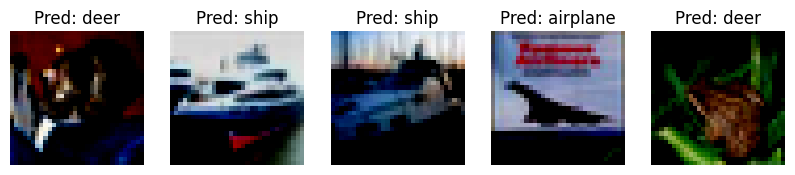

Epoch 262, Loss: 0.14993541166186333, Avg Batch Size: 81.2
Epoch 263, Loss: 0.19599047042429446, Avg Batch Size: 82.25
Epoch 264, Loss: 0.21066386811435223, Avg Batch Size: 79.9
Epoch 265, Loss: 0.16049487870186568, Avg Batch Size: 81.1
Epoch 266, Loss: 0.18120630607008933, Avg Batch Size: 81.65
Epoch 267, Loss: 0.19344040527939796, Avg Batch Size: 82.75
Epoch 268, Loss: 0.20603681467473506, Avg Batch Size: 81.15
Epoch 269, Loss: 0.19853871390223504, Avg Batch Size: 80.0
Epoch 270, Loss: 0.1746840164065361, Avg Batch Size: 81.15
Epoch 271, Loss: 0.18178655169904231, Avg Batch Size: 80.85
Epoch 272, Loss: 0.19102011546492575, Avg Batch Size: 81.4


KeyboardInterrupt: 

In [11]:
def train(model, labeled_loader, unlabeled_loader, test_loader, optimizer, device, epochs=400, threshold=0.9):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_batches = 0
        total_batch_size = 0  # To track average batch size per epoch

        # Create an iterator for unlabeled data
        unlabeled_iter = iter(unlabeled_loader)

        for labeled_data_weak, _, labels in labeled_loader:
            labeled_data_weak = labeled_data_weak.to(device)
            labels = labels.to(device)
            try:
                # Try to get a batch from unlabeled data
                unlabeled_data_weak, unlabeled_data_strong, _ = next(unlabeled_iter)
                unlabeled_data_weak = unlabeled_data_weak.to(device)
                unlabeled_data_strong = unlabeled_data_strong.to(device)
            except StopIteration:
                # Refresh iterator if the unlabeled loader is exhausted
                unlabeled_iter = iter(unlabeled_loader)
                unlabeled_data_weak, unlabeled_data_strong, _ = next(unlabeled_iter)
                unlabeled_data_weak = unlabeled_data_weak.to(device)
                unlabeled_data_strong = unlabeled_data_strong.to(device)

            # Generate pseudo-labels using weak augmentation
            with torch.no_grad():
                outputs = model(unlabeled_data_weak)
                soft_labels = torch.softmax(outputs, dim=1)
                max_probs, pseudo_labels = torch.max(soft_labels, dim=1)
                mask = max_probs > threshold

            # Generate high-confidence pseudo-labeled data
            if mask.sum() > 0:
                high_conf_data_strong = unlabeled_data_strong[mask]
                high_conf_labels = pseudo_labels[mask].to(device)
            else:
                high_conf_data_strong = torch.tensor([], device=device)
                high_conf_labels = torch.tensor([], dtype=torch.long, device=device)

            # Combine labeled and high-confidence pseudo-labeled data
            combined_data = torch.cat([labeled_data_weak, high_conf_data_strong], dim=0)
            combined_labels = torch.cat([labels, high_conf_labels], dim=0)

            # Forward pass
            outputs = model(combined_data)
            loss = criterion(outputs, combined_labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_batches += 1
            total_batch_size += combined_data.size(0)  # Track total batch size

        average_batch_size = total_batch_size / total_batches
        print(f'Epoch {epoch + 1}, Loss: {total_loss / total_batches}, Avg Batch Size: {average_batch_size}')

        # Visualization and accuracy every few epochs
        if epoch % 20 == 0 or epoch == epochs-1:
            accuracy, predicted = evaluate_model(model, device, test_loader)
            print(f'Epoch {epoch + 1}, Validation accuracy: {accuracy}')
            images, _ = next(iter(test_loader))
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            visualize_predictions(images.cpu(), predicted.cpu().numpy(), class_names)

train(model, labeled_loader, unlabeled_loader, test_loader, optimizer, device)

### (4) (Reinforement Learning)

* **Agent**: Learns from experiences to make decisions.
* **Environment**: Where the agent operates.
* **Action**: A set of decisions the agent can make.
* **State**: The current situation returned by the environment.
* **Reward**: Feedback from the environment to assess the actions.

**Carpole Game¶**
* **



In [12]:
  # pip install gym moviepy ipython

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Define the policy network
class PolicyNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)

# Define the value network
class ValueNet(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# The agent class
class PPOAgent:
    def __init__(self, env, gamma=0.99, lr=1e-3):
        self.env = env
        self.gamma = gamma
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = PolicyNet(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.value_net = ValueNet(env.observation_space.shape[0]).to(self.device)
        self.policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)
        self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=lr)
        print(f"Initialized agent with state space: {env.observation_space.shape}, action space: {env.action_space.n}")

    def select_action(self, state):
        state = state[0]
        state = np.array(state, dtype=np.float32)
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        probs = self.policy_net(state_tensor)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = self.value_net(state_tensor)
        return action.item(), log_prob, value

    def update_policy(self, rewards, log_probs, states, actions, values):
        discounts = [self.gamma ** i for i in range(len(rewards))]
        # Ensure rewards are on the same device
        rewards = torch.tensor(rewards, device=self.device).float()
        R = sum([a * b for a, b in zip(discounts, rewards)])

        policy_loss = []
        value_loss = []
        for log_prob, value, reward in zip(log_probs, values, rewards):
            advantage = R - value.item()
            policy_loss.append(-log_prob * advantage)
            value_loss.append(F.smooth_l1_loss(value, torch.tensor([R], device=self.device)))

        # Gradient descent for policy network
        self.policy_optimizer.zero_grad()
        sum(policy_loss).backward()
        self.policy_optimizer.step()

        # Gradient descent for value network
        self.value_optimizer.zero_grad()
        sum(value_loss).backward()
        self.value_optimizer.step()

    def train(self, max_episodes=500):
        for episode in range(max_episodes):
            state = self.env.reset()
            done = False
            log_probs = []
            values = []
            rewards = []
            actions = []
            while not done:
                action, log_prob, value = self.select_action(state)
                step_output = self.env.step(action)
                new_state, reward, done, *_ = step_output  # Using *_ to handle extra values
                log_probs.append(log_prob)
                values.append(value)
                rewards.append(reward)
                actions.append(action)
                state = new_state
            self.update_policy(rewards, log_probs, state, actions, values)
            print(f'Episode {episode + 1}, Total reward: {sum(rewards)}')

# Create the environment
env = gym.make('CartPole-v1')

# Create and train the agent
agent = PPOAgent(env)
agent.train()
env.close()

Initialized agent with state space: (4,), action space: 2


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 4x64)

* Save models and save the interactive game to .mp4

In [ ]:
torch.save(agent.policy_net.state_dict(), 'results/ppo_policy_net.pth')
torch.save(agent.value_net.state_dict(), 'results/ppo_value_net.pth')
print("Models saved successfully.")

In [ ]:
from IPython.display import Video, display
import moviepy.editor as mpy

def save_video(frames, filename='results/gameplay.mp4', fps=30):
    clip = mpy.ImageSequenceClip(frames, fps=fps)
    clip.write_videofile(filename, codec='libx264')
    return filename

env = gym.make('CartPole-v1', render_mode='rgb_array')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = PPOAgent(env)
agent.policy_net.load_state_dict(torch.load('results/ppo_policy_net.pth'))
agent.policy_net.to(device)

frames = []
state = env.reset()
for t in range(300):
    frame = env.render()
    frames.append(frame)
    action, _, _ = agent.select_action(state)
    state, reward, done, info, *_ = env.step(action)
    if done:
        break
env.close()

video_path = save_video(frames)
display(Video(video_path, embed=True))